<h1><center>Homework 3</center></h1>

<h3>Submission Instructions</h3>
<p>
For submission, you only need to submit your Jupyter Notebook file named "StudentName_ID.ipynb"

If you have any questions, you can contact me via kamard@itu.edu.tr
</p>

<h3> Homework Instructions </h3>

<p>In this homework, you will implement Girvan-Newman algorithm, and use the algorithm to decompose the network into a number of modules so that it has the highest modularity. Remember the steps of Girvan-Newman algorithm from Graph Theory Blink 9.3:

<ol>
  <li>Calculate the betweenness centrality of each edge in graph G</li>
  <li>Remove the edge with the highest betweenness centrality. Choose randomly in case same score occurs.</li>
  <li>Recalculate the betweenness centrality of all remaining edges</li>
  <li>Repeat steps 2 and 3 until no edges remain. </li>
</ol>

You will need to modify the above steps so that you find the number of connected components that has the highest modularity. To do that, you can calculate modularity each time new connected component is formed during the Girvan-Newman algorithm, and find the decomposition with highest modularity. Don't forget to compute the modularity of the initial network, as network might not consist any modules 

<h2>WHAT YOU NEED TO DO</h2>
<ol>
    <li> Read and visualize the given graph adjacency matrix files. Give brief comments about the networks' hiearchy and modularity <b>(20p)</b>
    <li> Implement the Girvan-Newman algorithm: Write a function that uses Girvan-Newman algorithm to find the number of connected components that gives the highest modularity. In the same function or another function, return the new graph with the number of connected components you have found (basically, remove edges until the number of connected components are equal to the one you found with your algorithm). <b>(60p)</b>
    <li> Visualize the final results. <b>(10p)</b>
    <li> What conclusions can you derive about the networks after you run the algorithm on them and visualize the final result? Give brief comments. <b>(10p)</b>

Below, I have given you some basic functions to start with. 
</p>

In [1]:
import numpy as np
import networkx as nx
import networkx.algorithms.community as nx_comm
import matplotlib.pyplot as plt

You can use RandomGraph function to create a random graph that returns the graph as both networkx.Graph and adjacency matrix as numpy.array.

(Optional, will not affect your grade) You can modify the VisualiseGraph function to give each connected component different graph, or make other interesting visualizations. Play with it however you want!

In [2]:
def RandomAdjacencyMatrix(n = 10, p = 0.5):
    M = np.zeros((n,n), dtype=np.uint8)
    for i in range(n):
        for j in range(i+1, n):
            if np.random.rand() < p:
                M[i,j], M[j, i] = 1, 1
    return M

def RandomGraph(n = 10, p = 0.5):
    '''
    Creates a random networkx undirected, unweighted graph
    
    Inputs:
        n: number of nodes in graph
        p: probability of an edge being included
        
    Outputs:
        M: Adjacency matrix as numpy array
        G: nx Graph
        
    '''
    M = RandomAdjacencyMatrix(n, p)
    edges = np.transpose(np.where(M==1))
    
    G = nx.Graph()
    for i in range(edges.shape[0]):
        G.add_edge(edges[i, 0], edges[i, 1])
    
    return G, M

def VisualizeGraph(G):
    nx.draw_networkx(G)
    plt.show()
    

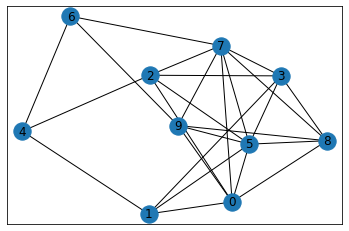

In [3]:
n = 10
p = 0.5
G, M = RandomGraph(n, p)
VisualizeGraph(G)

## You can start from here.

Implement all your codes and write all your comments below this cell. 

For the algorithm; you are only allowed to use networkx to compute <b>modularity, connected components and betwenness centralities.</b> You need to implement Girvan-Nerman and rest of the algorithm by yourself. 

### Loading .npy files

In [4]:
network1_adj = np.load("NetworkData1.npy")
network2_adj = np.load("NetworkData2.npy")
network3_adj = np.load("NetworkData3.npy")

network_adjs = [network1_adj, network2_adj, network3_adj]
network_Gs = [nx.from_numpy_array(adj) for adj in network_adjs]

### 1. Read and visualize the given graph adjacency matrix files. Give brief comments about the networks' hiearchy and modularity 

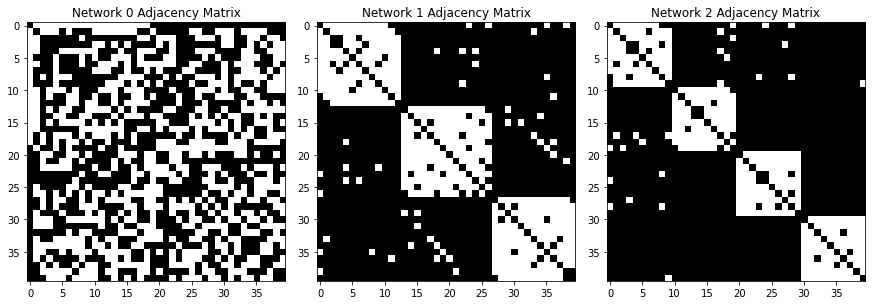

Network 0 Modularity: 0.0
Network 1 Modularity: 1.1102230246251565e-16
Network 2 Modularity: 0.0


In [5]:
fig, axs = plt.subplots(1,3, figsize=(12, 5), constrained_layout=True)

for i, adj in enumerate(network_adjs):
    axs[i].title.set_text("Network "+str(i)+" Adjacency Matrix")
    axs[i].imshow(adj, cmap="gray")

plt.show()

for i, gr in enumerate(network_Gs):
    cc = [cc_ for cc_ in nx.connected_components(gr)]
    modularity = nx_comm.modularity(gr, cc)
    print("Network", i , "Modularity:", modularity)

As it can be easily seen, the graphs' modularities stays at zero. It can be because of both lack of in-module connection amount or reduncancy of between-module connection amount. Because, we need small number of between-module connections and large number of in-module connections.

When we look at the matrices, we can foresee that the reason of the low modularity is the large amount of between-module connections. The second and third graphs have clear modules, but there are many between-module connections. We can't easily see a modular structure in the first graph, but by pruning we may force them to occur. We need to prune unnecessary edges that provide between-module connections to increase modularity. We are going to do that by using the Girvan-Newman algorithm.

For the first graph we can say that it's simply a dense graph, there are no clusters that have sharp boundaries. The second and third graphs have a few core-peripheral structures. And they have connections between some of these peripherals of different clusters. This way, the clusters become connected.


### 2. Implement the Girvan-Newman algorithm: Write a function that uses Girvan-Newman algorithm to find the number of connected components that gives the highest modularity. In the same function or another function, return the new graph with the number of connected components you have found (basically, remove edges until the number of connected components are equal to the one you found with your algorithm).

In [6]:
def girvan_newman(Adj):
    
    A = Adj.copy()
    G = nx.from_numpy_array(A)
    
    best_modularity = 0.
        
    init_G = G.copy()
    
    while True:
        
        init_ccc = nx.number_connected_components(G)
        curr_ccc = init_ccc
        curr_cc = list(nx.connected_components(G))    
        
        while curr_ccc <= init_ccc:
            bw_cents = nx.edge_betweenness_centrality(G) ## getting edge betweenness centralities
            max_bw_val = max(bw_cents.values()) # get maximum betweenness value
            max_bw_edge = max(bw_cents, key=bw_cents.get) ## selecting the edge to remove
            G.remove_edge(*max_bw_edge) ## removing the edge     
            curr_ccc = nx.number_connected_components(G)

        curr_cc = list(nx.connected_components(G)) ## updating the connected components
        modularity = nx_comm.modularity(init_G, curr_cc) ## calculating the modularity

        if modularity>best_modularity: ## best modularity checkpoint
            best_modularity = modularity
            best_modularity_ccc = curr_ccc
            best_G = G.copy()  
        
        if G.number_of_edges() == 0: ## terminating the loop
            break
        
    best_Adj = nx.to_numpy_matrix(best_G) ## getting the best graph's adj matrix
                                  
    return best_G, best_Adj, best_modularity, best_modularity_ccc

In [7]:
network1_girvan, network1_girvan_adj, network1_modularity, network1_ccc = girvan_newman(network1_adj)
network2_girvan, network2_girvan_adj, network2_modularity, network2_ccc = girvan_newman(network2_adj)
network3_girvan, network3_girvan_adj, network3_modularity, network3_ccc = girvan_newman(network3_adj)

network_girvan_adjs = [network1_girvan_adj, network2_girvan_adj, network3_girvan_adj]
network_girvan_Gs = [network1_girvan, network2_girvan, network3_girvan]
network_girvan_mods = [network1_modularity, network2_modularity, network3_modularity]
network_girvan_cclens = [network1_ccc, network2_ccc, network3_ccc]

### 3. Visualize the final results

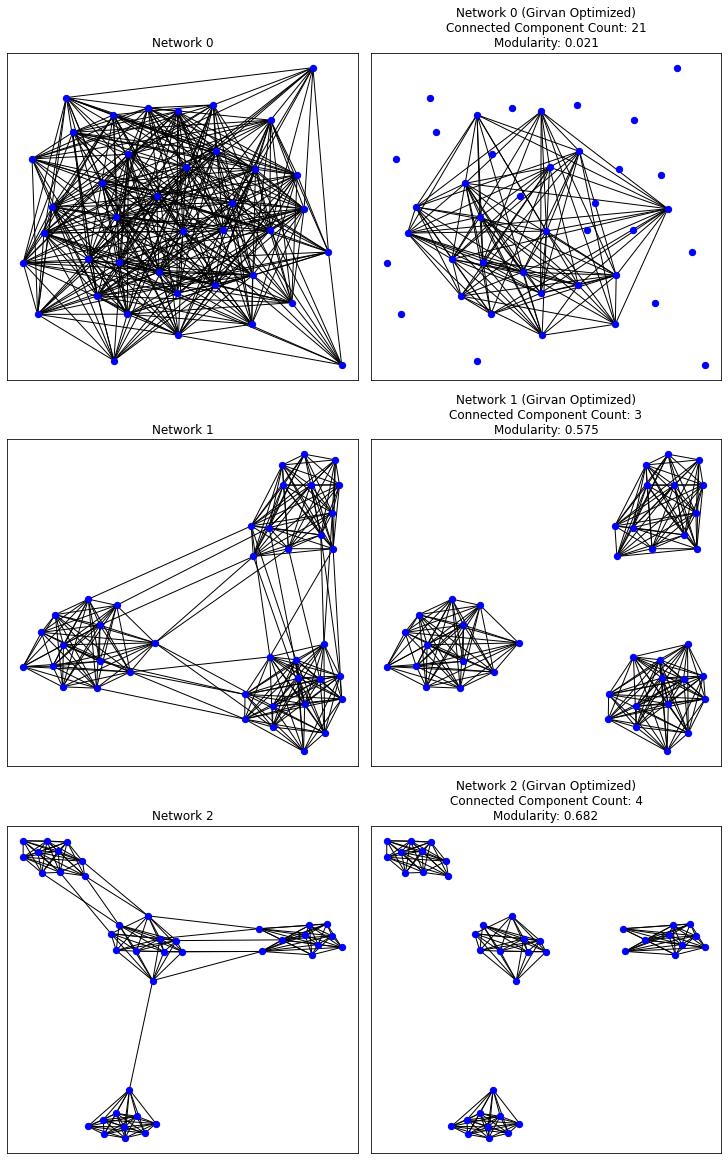

In [8]:
fig, axs = plt.subplots(3,2, figsize=(10, 16), constrained_layout=True)

for i, gr in enumerate(network_Gs):
    axs[i,0].title.set_text("Network "+str(i))
    pos = nx.spring_layout(gr)
    nx.draw(gr, node_size=40, node_color='b', ax=axs[i,0], pos=pos)
    axs[i,0].axis('on')

    modval = np.round(network_girvan_mods[i], 3)

    axs[i,1].title.set_text("Network "+str(i)+" (Girvan Optimized)\nConnected Component Count: "+str(network_girvan_cclens[i])+"\nModularity: "+str(modval))
    nx.draw(network_girvan_Gs[i], node_size=40, node_color='b', ax=axs[i,1], pos=pos)
    axs[i,1].axis('on')

plt.show()

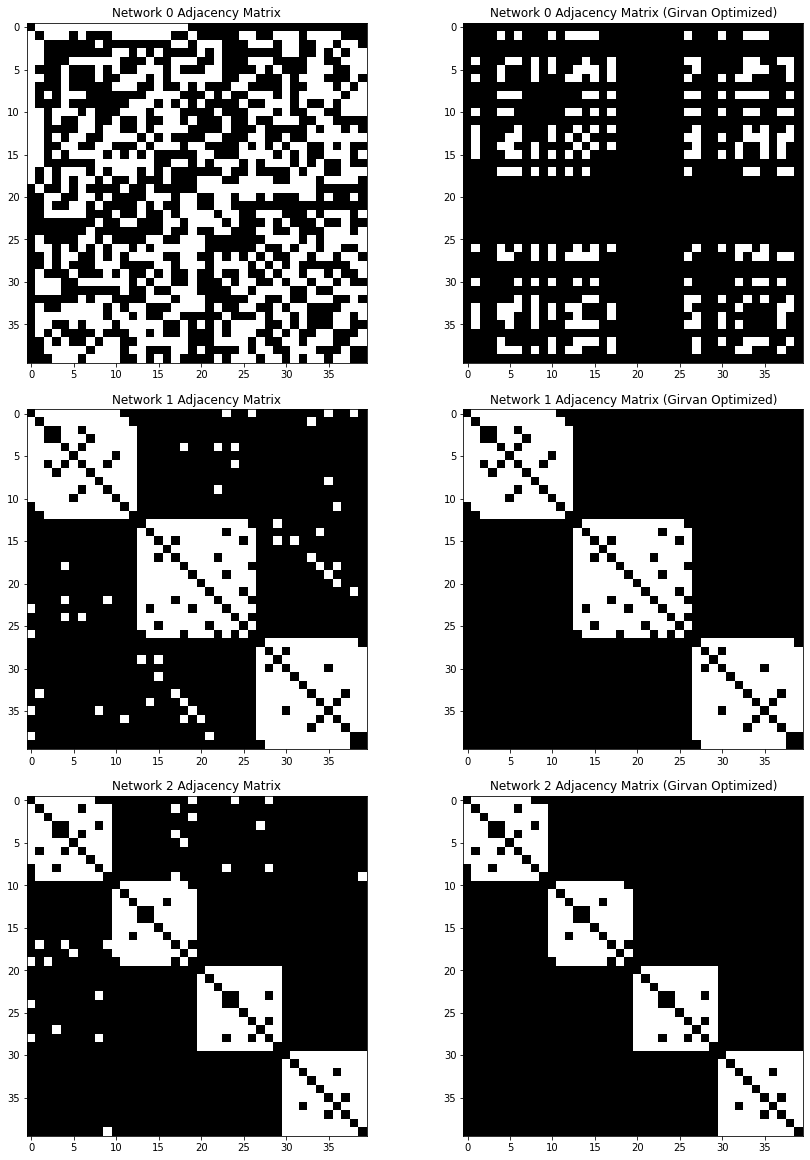

In [9]:
fig, axs = plt.subplots(3,2, figsize=(12, 16), constrained_layout=True)

for i, adj in enumerate(network_adjs):
    axs[i,0].title.set_text("Network "+str(i)+" Adjacency Matrix")
    axs[i,0].imshow(adj, cmap="gray")

    axs[i,1].title.set_text("Network "+str(i)+" Adjacency Matrix (Girvan Optimized)")
    axs[i,1].imshow(network_girvan_adjs[i], cmap="gray")
    
plt.show()

### 4. What conclusions can you derive about the networks after you run the algorithm on them and visualize the final result? Give brief comments.

We can see that the algorithm have pruned the edges that aren't belong to a module for the second and third graph. Remaining edges create 4 and 3 discrete modules, respectively. But the algorithm also caused a discreteness. By discreteness, what I'm trying to mean is there is no between-module connection anymore. This makes our new graphs not-conneced.

We weren't able to see a clear module in the first graph. But we have 21 different connected components now. 20 of them are single nodes, and the remaining connected component consists of remaining nodes and edges. These 20 nodes and the remaining node cluster are also not connected.